In [121]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
import numpy as np

launch.json used to generate epoch-wise pkls

In [ ]:
# {
#     "version": "0.2.0",
#     "configurations": [
#    	 {
#    		 "name": "Run with argument",
#    		 "type": "python",
#    		 "request": "launch",
#    		 "program": "${file}",
#    		 "console": "integratedTerminal",
#    		 "cwd": "${workspaceFolder}/tools",
#    		 "env": {"CUDA_VISIBLE_DEVICES": "1"},
#    		 "args": ["--cfg_file" ,
#            		 "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
#            		 "--split",
#            		 "train_0.01_1",
#            		 "--batch_size",
#            		 "8",
#            		 "--ckpt_save_interval",
#            		 "20",
#            		 "--repeat",
#            		 "5",
#            		 "--fix_random_seed",
#            		 "--extra_tag",
#            		 "tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader",
#            		 "--dbinfos",
#            		 "kitti_dbinfos_train_0.01_1_37.pkl",
#                  "--epochs", // for repeat 5, bsz 8: to cover 3769 ulb frames needs ~21 epochs
#                  "100",
#                  "--ckpt",
#                  "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/ckpts_3diou_split_1_1_0fbd0d1/ckpt/checkpoint_epoch_60.pth",
#                 "--set",
#                  "MODEL.STORE_SCORES_IN_PKL",
#                 "True"
#    		 ],
#    	 }
#     ]
# }


Script to read epoch wise pkls, combine and store as ckptX_snapshot_data

In [122]:
import os
import pickle
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/kitti_models/pv_rcnn_ssl_60/debug_frame_id_pkl_2_e07069b/"

# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_gt_data = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_gt_data:
            snapshot_gt_data[key] = []
        snapshot_gt_data[key].extend(value)



In [123]:
snapshot_gt_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'roi_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt', 'instance_idx', 'labeled_mask', 'unlabeled_mask', 'ori_gt_boxes', 'assigned_pl_inds', 'assigned_iou_pl_class', 'gt_obj_scores'])

In [198]:
len(snapshot_gt_data['frame_id'])

385

In [199]:
labeled_mask_arr = np.array(snapshot_gt_data['labeled_mask'])

(385,)

In [127]:
len(snapshot_gt_data['ori_gt_boxes'])

385

In [128]:
len(snapshot_gt_data['shared_features_gt'])

385

In [202]:
# print(" Total number of iterations", ckpt20_snapshot_data['iteration'][-1])
# Convert the lists to numpy arrays for boolean indexing
labeled_mask_np = np.array(snapshot_gt_data['labeled_mask'])
frame_id_np = np.array(snapshot_gt_data['frame_id'])

# Use boolean indexing to filter frame_id where labeled_mask == 0
lb_frame_ids = frame_id_np[labeled_mask_np == 1]
print(len(lb_frame_ids))
print(np.unique(lb_frame_ids).shape)

ulb_frame_ids = frame_id_np[labeled_mask_np == 0]
print(len(ulb_frame_ids))
print(np.unique(ulb_frame_ids).shape)

37
(37,)
348
(348,)


In [203]:
# To CPU
for i in range(len(snapshot_gt_data['gt_obj_scores'])):
    snapshot_gt_data['gt_obj_scores'][i] = snapshot_gt_data['gt_obj_scores'][i].cpu()
    snapshot_gt_data['ori_gt_boxes'][i] = snapshot_gt_data['ori_gt_boxes'][i].cpu()

In [204]:
import torch

# Initialize an empty list to store concatenated tensors
labeled_gt_obj_scores_list = []
unlabeled_gt_obj_scores_list = []

labeled_gt_classes_list = []
unlabeled_gt_classes_list = []

labeled_gt_sh_ft_list = []
unlabeled_gt_sh_ft_list = []

# Iterate over the labeled mask and corresponding tensors
for mask, tensor in zip(snapshot_gt_data['labeled_mask'], snapshot_gt_data['gt_obj_scores']):
    if mask == 1:
        labeled_gt_obj_scores_list.append(tensor)
    if mask == 0:
        unlabeled_gt_obj_scores_list.append(tensor)

for mask, tensor in zip(snapshot_gt_data['labeled_mask'], snapshot_gt_data['ori_gt_boxes']):
    if mask == 1:
        labeled_gt_classes_list.append(tensor[:,-1])
    if mask == 0:
        unlabeled_gt_classes_list.append(tensor[:,-1])


for mask, tensor in zip(snapshot_gt_data['labeled_mask'], snapshot_gt_data['shared_features_gt']):
    if mask == 1:
        labeled_gt_sh_ft_list.append(tensor)
    if mask == 0:
        unlabeled_gt_sh_ft_list.append(tensor)


In [205]:
import numpy as np

lbl_gt_obj_scores= np.concatenate(labeled_gt_obj_scores_list)
lbl_gt_classes = np.concatenate(labeled_gt_classes_list)
lbl_gt_sh_ft = np.concatenate(labeled_gt_sh_ft_list)

ulb_gt_obj_scores= np.concatenate(unlabeled_gt_obj_scores_list)
ulb_gt_classes = np.concatenate(unlabeled_gt_classes_list)
ulb_gt_sh_ft = np.concatenate(unlabeled_gt_sh_ft_list)

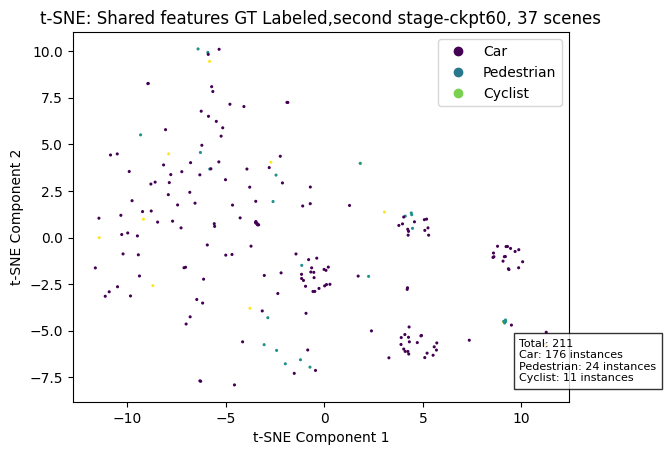

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = lbl_gt_sh_ft
y = lbl_gt_classes.astype(int)
conf_scores = lbl_gt_obj_scores
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"t-SNE: Shared features GT Labeled,second stage-ckpt60, {np.unique(lb_frame_ids).shape[0]} scenes"
plt.title(title)

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

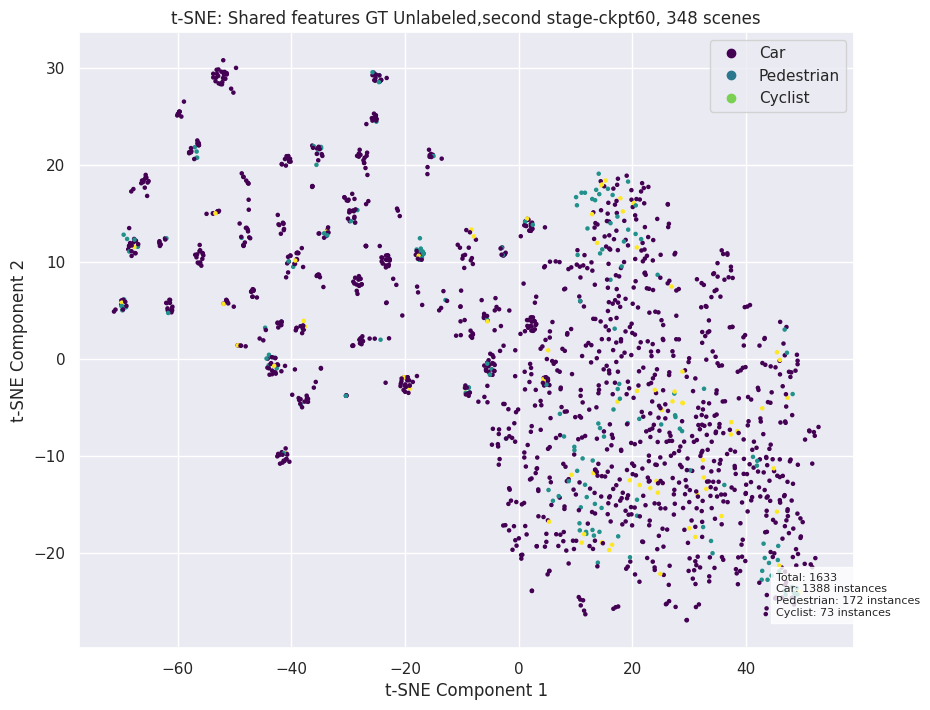

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"t-SNE: Shared features GT Unlabeled,second stage-ckpt60, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)
# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [224]:
def get_objectness_tp_fp(x, y, conf_scores,thresh):

    x = x
    y = y.astype(int)

    car_mask = y==0
    ped_mask = y==1
    cyc_mask = y==2

    conf_scores_car = conf_scores[car_mask]
    conf_scores_ped = conf_scores[ped_mask]
    conf_scores_cyc = conf_scores[cyc_mask]

    conf_scores_car = conf_scores_car>= thresh[0]
    conf_scores_ped = conf_scores_ped>= thresh[1]
    conf_scores_cyc = conf_scores_cyc>=thresh[2]
    conf_scores_car = conf_scores_car.astype(int)
    conf_scores_ped = conf_scores_ped.astype(int)
    conf_scores_cyc = conf_scores_cyc.astype(int)

    shape_diff = tuple((target - current) for target, current in zip(conf_scores.shape, conf_scores_car.shape))
    padding = tuple((0, diff) for diff in shape_diff)
    conf_scores_car_padded =  np.pad(conf_scores_car, padding, mode='constant', constant_values=-1)
    shape_diff = tuple((target - current) for target, current in zip(conf_scores.shape, conf_scores_ped.shape))
    padding = tuple((0, diff) for diff in shape_diff)
    conf_scores_ped_padded =  np.pad(conf_scores_ped, padding, mode='constant', constant_values=-1)
    shape_diff = tuple((target - current) for target, current in zip(conf_scores.shape, conf_scores_cyc.shape))
    padding = tuple((0, diff) for diff in shape_diff)
    conf_scores_cyc_padded =  np.pad(conf_scores_cyc, padding, mode='constant', constant_values=-1)

    tsne_colors = {'0': conf_scores_car_padded,  '1': conf_scores_ped_padded, '2': conf_scores_cyc_padded}

    return tsne_colors

In [225]:
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)


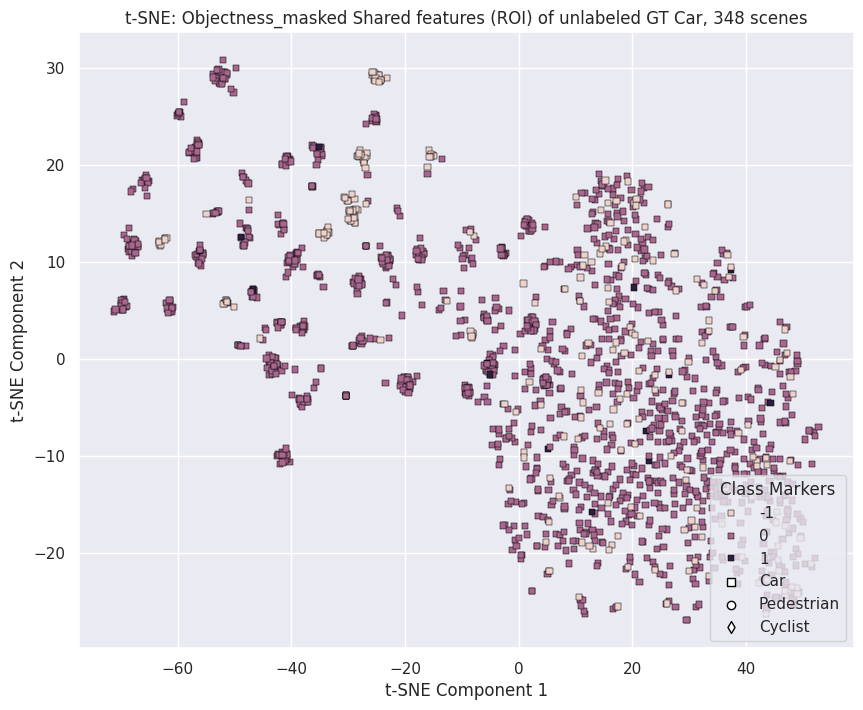

In [240]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

sns.set(style='darkgrid')

# Define marker styles
markers = ["s","o","d"]


plt.figure(figsize=(10, 8))
# Plot t-SNE components
start=0
while start < 1:
    key = str(start)
    sns.scatterplot(x = x_tsne[:, 0], y =  x_tsne[:, 1], marker = markers[start], s = 20, edgecolor = 'black', hue = tsne_colors[key], legend= True)
    start+=1


# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"t-SNE: Objectness_masked Shared features (ROI) of unlabeled GT Car, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)

class_names = ['Car', 'Pedestrian', 'Cyclist']
# Plot dummy points with markers
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name,edgecolor = 'black')  # Set color to white
# Create legend
plt.legend(title='Class Markers', loc='lower right')  # Move legend to bottom right



# Show plot
plt.show()


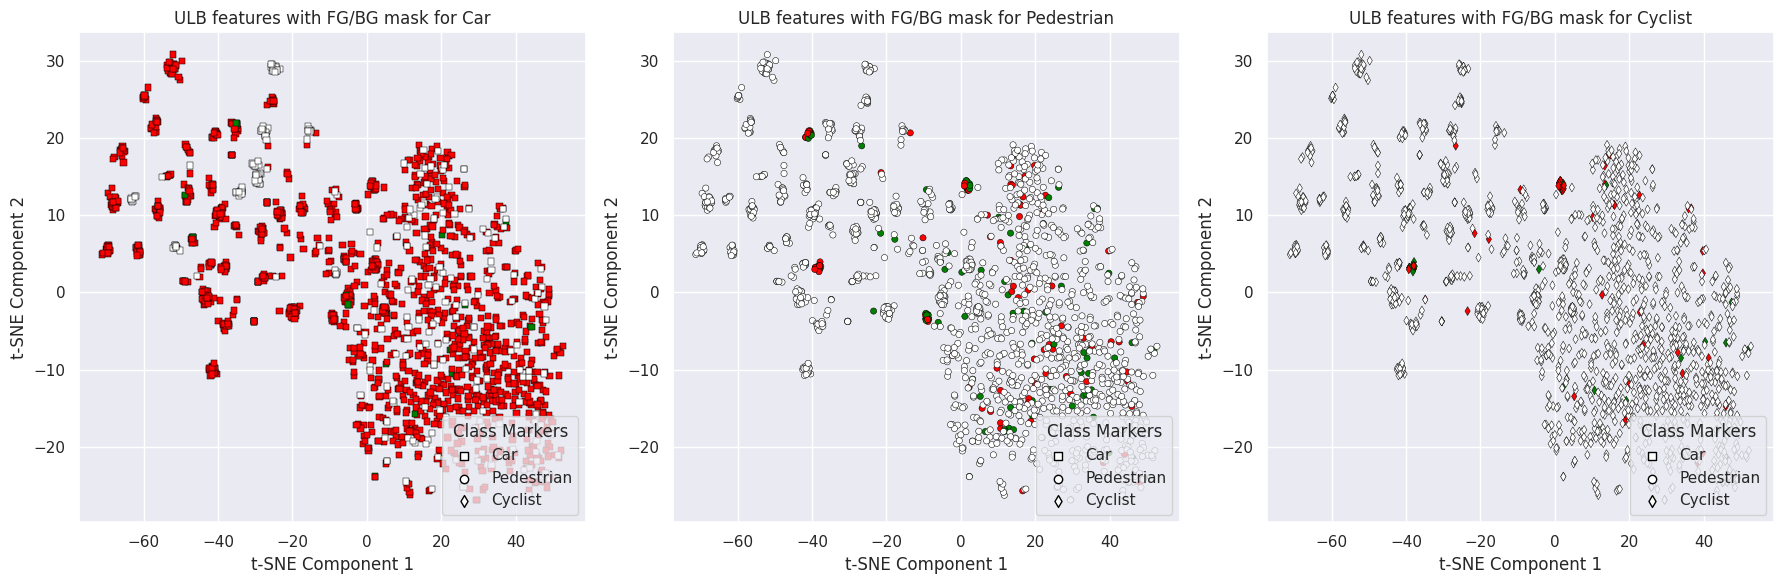

In [243]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

sns.set(style='darkgrid')

# Define marker styles
markers = ["s", "o", "d"]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Creating 3 subplots side by side
class_names = ['Car', 'Pedestrian', 'Cyclist']

for start, ax in enumerate(axs):
    start_key = str(start)
    # Plot t-SNE components
    sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], marker=markers[start], s=20, edgecolor='black',
                    hue=tsne_colors[start_key], palette={1: 'green', 0: 'red', -1 : 'white'}, legend=False, ax=ax)
    # Set labels and title for each subplot
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title(f"ULB features with FG/BG mask for {class_names[start]}")

    # Plot dummy points with markers
    for marker, class_name in zip(markers, class_names):
        ax.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

    # Create legend
    ax.legend(title='Class Markers', loc='lower right')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

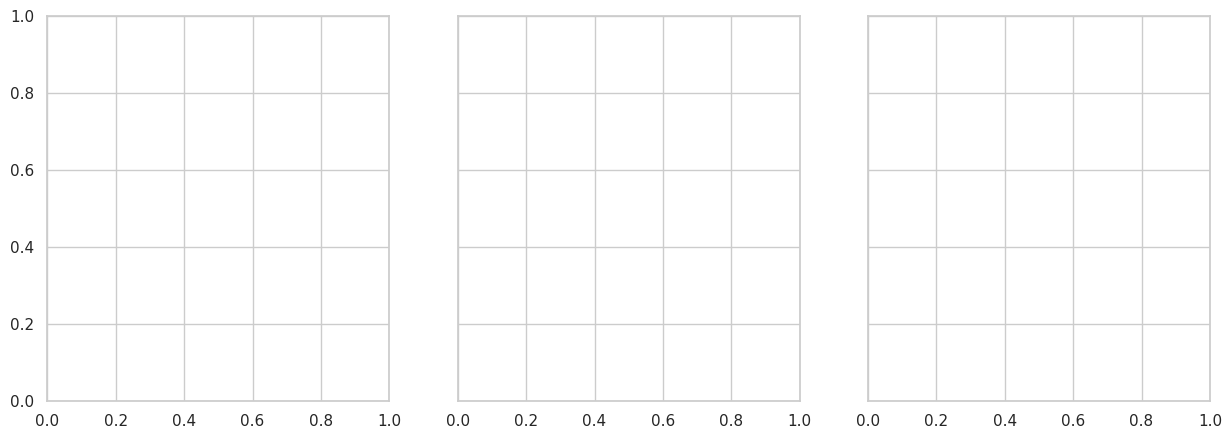

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

# Set seaborn style
sns.set(style='whitegrid')

# Define marker styles
markers = ["s", "o", "d"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Plot t-SNE components for each key value
for key, ax in zip(tsne_colors.keys(), axes):
        sns.scatterplot(
            x=x_tsne[:, 0],
            y=x_tsne[:, 1],
            marker=markers[int(key)],
            s=30,
            # edgecolor='',
            hue=tsne_colors,
            palette={1: 'green', 0: 'red', -1 : 'white'},  # Bind colors to True and False
            legend='full',  # Show legend
            ax=ax  # Set the current subplot
        )
    # Set labels and title for each subplot
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.set_title(f"Key Value: {key}")

# Plot dummy points with markers for class names on the last subplot
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    axes[-1].scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names on the last subplot
axes[-1].legend(title='Class Markers', loc='upper right')  # Move legend to bottom right

# Show plot
plt.tight_layout()
plt.show()

In [179]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
x_tsne.shape

(1633, 2)

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

# Set seaborn style
sns.set(style='whitegrid')

# Define marker styles
markers = ["s", "o", "d"]

plt.figure(figsize=(10, 8))

# Plot t-SNE components
for start, marker in enumerate(markers):
    key = str(start)
    if tsne_colors[key] != -1:  # Check if tsne_colors[key] is not -1
        sns.scatterplot(
            x=x_tsne[:, 0],
            y=x_tsne[:, 1],
            marker=marker,
            s=30,
            # edgecolor='',
            hue=tsne_colors[key],
            palette={ 1: 'green', 0: 'red'},  # Bind colors to True and False
            legend='full'  # Show legend
        )

# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"TP/FP masked Tsne for ulb_GT_objectness, second_stage, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)

# Plot dummy points with markers for class names
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names
plt.legend(title='Class Markers', loc='upper right')  # Move legend to bottom right

class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.02, 0.02, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))
# Show plot
plt.show()


ValueError: If using all scalar values, you must pass an index

<Figure size 1000x800 with 0 Axes>

In [ ]:
# def get_max_iou(anchors, gt_boxes, gt_classes, matched_threshold=0.6):
#     num_anchors = anchors.shape[0]
#     num_gts = gt_boxes.shape[0]

#     ious = torch.zeros((num_anchors,), dtype=torch.float, device=anchors.device)
#     labels = torch.ones((num_anchors,), dtype=torch.int64, device=anchors.device) * -1
#     gt_to_anchor_max = torch.zeros((num_gts,), dtype=torch.float, device=anchors.device)

#     if len(gt_boxes) > 0 and anchors.shape[0] > 0:
#         anchor_by_gt_overlap = iou3d_nms_utils.boxes_iou3d_gpu(anchors[:, 0:7], gt_boxes[:, 0:7])
#         gt_to_anchor_max = anchor_by_gt_overlap.max(dim=0)[0]
#         anchor_to_gt_argmax = anchor_by_gt_overlap.argmax(dim=1)
#         anchor_to_gt_max = anchor_by_gt_overlap[torch.arange(num_anchors, device=anchors.device), anchor_to_gt_argmax]

#         pos_inds = anchor_to_gt_max >= matched_threshold
#         gt_inds_over_thresh = anchor_to_gt_argmax[pos_inds]
#         labels[pos_inds] = gt_classes[gt_inds_over_thresh]
#         ious[:] = anchor_to_gt_max

#     return ious, labels, gt_to_anchor_max

In [148]:
labeled_mask_np = np.array(ckpt60_snapshot_data['labeled_mask'])
frame_id_np = np.array(ckpt60_snapshot_data['frame_id'])
lb_frame_ids = frame_id_np[labeled_mask_np == 1]
vals,indices = np.unique(lb_frame_ids,return_index=True)
print(len(np.sort(indices)))
unique_lb_frame_mask = np.sort(indices)

37


In [158]:
np.array(ckpt60_snapshot_data['shared_features_gt']).shape

(212821, 256)

In [149]:
lb_obj_scores = np.array(ckpt60_snapshot_data['obj_scores'])
lb_obj_scores = lb_obj_scores[unique_lb_frame_mask]

lb_shared_features_gt = np.array(ckpt60_snapshot_data['shared_features_gt'])
lb_shared_features_gt = lb_shared_features_gt[unique_lb_frame_mask]
print(len(lb_shared_features_gt))

lb_ori_gt_boxes = np.array(ckpt60_snapshot_data['ori_gt_boxes'])
lb_ori_gt_classes = lb_ori_gt_boxes[:,-1]
lb_ori_gt_classes = lb_ori_gt_classes[unique_lb_frame_mask]
print(len(lb_ori_gt_classes))

lb_gt_conf_scores = np.array(ckpt60_snapshot_data['gt_obj_scores'])
lb_gt_conf_scores = lb_gt_conf_scores[unique_lb_frame_mask]
print(len(lb_gt_conf_scores))

37
37
37


In [154]:
# util function for getting TP/FP for objectness


def get_objectness_tp_fp(x_tsne, y_tsne, conf_scores,thresh):
    unique_classes = np.unique(y_tsne)
    x_tsne_dict = {}
    y_pred_dict = {}

    for class_label in unique_classes:
        class_mask = y_tsne == class_label
        x_tsne_class = np.zeros_like(x_tsne)
        x_tsne_class[class_mask] = x_tsne[class_mask]
        x_tsne_dict[class_label] = x_tsne_class

        tmp = np.zeros_like(conf_scores)
        tmp = conf_scores * class_mask 
        tmp = tmp >= gt_iou_thresh[class_label]
        y_pred_dict[class_label] = tmp

    return x_tsne_dict, y_pred_dict

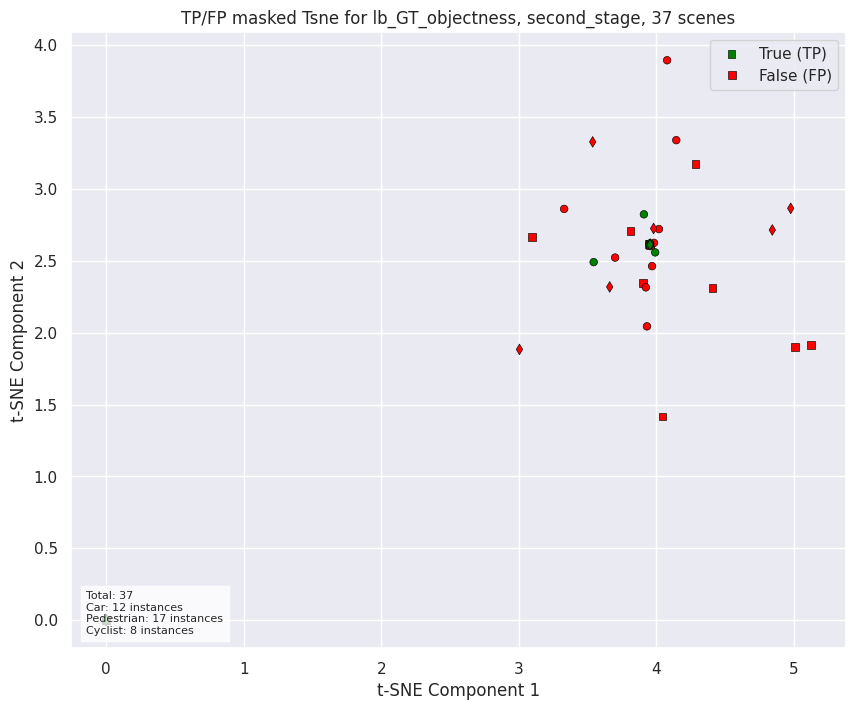

In [157]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = lb_shared_features_gt
y = lb_ori_gt_classes.astype(int)
conf_scores = lb_gt_conf_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
x_tsne_dict, y_tsne_dict = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)
tp_fp_labels = y_tsne_dict[0] + y_tsne_dict[1] + y_tsne_dict[2]

# Set seaborn style
sns.set(style='darkgrid')

# Define marker styles
markers = ["s", "o", "d"]

plt.figure(figsize=(10, 8))

# Plot t-SNE components
for start, marker in enumerate(markers):
    sns.scatterplot(
        x=x_tsne_dict[start][:, 0],
        y=x_tsne_dict[start][:, 1],
        marker=marker,
        s=30,
        edgecolor='black',
        hue=tp_fp_labels,
        palette={True: 'green', False: 'red'},  # Bind colors to True and False
        legend='full'  # Show legend
    )

# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"TP/FP masked Tsne for lb_GT_objectness, second_stage, {np.unique(lb_frame_ids).shape[0]} scenes"
plt.title(title)

# Plot dummy points with markers for class names
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names
plt.legend(title='Class Markers', loc='lower right')  # Move legend to bottom right

# Create separate legend for True (TP) and False (FP)
plt.legend(['True (TP)', 'False (FP)'], loc='upper right')

class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.02, 0.02, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))
# Show plot
plt.show()



In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the first t-SNE plot
# scatter1 = axs[0].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
# axs[0].set_xlabel('t-SNE Component 1')
# axs[0].set_ylabel('t-SNE Component 2')
# axs[0].set_title('t-SNE : Shared features ROI, end of Pretrain, 3dioumatch-org')

# # Plot the second t-SNE plot
# scatter2 = axs[1].scatter(x_tsne_gt[:, 0], x_tsne_gt[:, 1], c=y_gt, cmap='viridis', s=1.5)
# axs[1].set_xlabel('t-SNE Component 1')
# axs[1].set_ylabel('t-SNE Component 2')
# axs[1].set_title('t-SNE : Shared features GT, end of Pretrain, 3dioumatch-org')

# class_counts = np.bincount(y)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))


# class_counts = np.bincount(y_gt)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# # Set equal aspect ratio for both plots
# axs[0].axis('equal')
# axs[1].axis('equal')

# plt.show()